In [1]:
from google.cloud import bigquery
import pandas_gbq
%load_ext google.cloud.bigquery

# Set your default project here
pandas_gbq.context.project = 'snappy-boulder-378707'
pandas_gbq.context.dialect = 'standard'

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../BigQuery/letsgo-snappy-boulder-378707-4b7d46801fd1.json"

# Construct a BigQuery client object.
client = bigquery.Client()

from statsmodels.formula.api import ols

from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

# Retrieve Data

In [2]:
%%bigquery audio_features
SELECT * FROM snappy-boulder-378707.AudioFeatures.AudioFeatures


Query is running:   0%|          |

Downloading:   0%|          |

In [3]:
%%bigquery genre
SELECT * FROM snappy-boulder-378707.TrackGenre.Trackgenre


Query is running:   0%|          |

Downloading:   0%|          |

In [4]:
genre_unpivot = genre.melt(
    id_vars=['track_id'], var_name='genre', value_name='binary')
genre_unpivot = genre_unpivot[genre_unpivot["binary"] == 1]
genre_unpivot


,track_id,genre,binary
10,003vvx7Niy0yvhvHt4a68B,Alternative,1
14,0085Y1oLaWiAB94I4iQo8N,Alternative,1
54,00YCRrySf0dJ6nRCKYSAkA,Alternative,1
61,00cn1ynXQhURwsgv69fN0b,Alternative,1
68,00kG2B5W9MQYdPxrICYhNg,Alternative,1
...,...,...,...
1396958,7zvUaHQrp6Pr3UG743kmP5,Rock,1
1396963,7zy7iE31dGO70ShMXghsfj,Rock,1
1402824,2hKdd3qO7cWr2Jo0Bcs0MA,Rock,1
1414789,0jWgAnTrNZmOGmqgvHhZEm,Rock,1


In [5]:
genre_unpivot = genre_unpivot.drop(['binary'], axis=1)
df = pd.merge(genre_unpivot, audio_features, how="inner",
              left_on="track_id", right_on="id")
df  # 85637 row: higher than audio features' row - might be repetitive songs


,track_id,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,003vvx7Niy0yvhvHt4a68B,Alternative,0.352,0.911,1,-5.230,1,0.0747,0.00121,0.000,0.0995,0.236,148.033,003vvx7Niy0yvhvHt4a68B,222973,4
1,003vvx7Niy0yvhvHt4a68B,Indie,0.352,0.911,1,-5.230,1,0.0747,0.00121,0.000,0.0995,0.236,148.033,003vvx7Niy0yvhvHt4a68B,222973,4
2,003vvx7Niy0yvhvHt4a68B,Pop,0.352,0.911,1,-5.230,1,0.0747,0.00121,0.000,0.0995,0.236,148.033,003vvx7Niy0yvhvHt4a68B,222973,4
3,0085Y1oLaWiAB94I4iQo8N,Alternative,0.626,0.560,0,-11.892,0,0.0277,0.51300,0.819,0.1790,0.296,108.042,0085Y1oLaWiAB94I4iQo8N,117500,4
4,0085Y1oLaWiAB94I4iQo8N,Indie,0.626,0.560,0,-11.892,0,0.0277,0.51300,0.819,0.1790,0.296,108.042,0085Y1oLaWiAB94I4iQo8N,117500,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85632,7yZvWX3xZ50oh555vREpin,Rock,0.800,0.767,0,-13.148,0,0.1030,0.52000,0.333,0.3120,0.737,128.175,7yZvWX3xZ50oh555vREpin,214160,4
85633,7zKieV1uXBhucwmYM4sCzW,Rock,0.634,0.890,5,-2.618,0,0.0422,0.00719,0.000,0.3320,0.838,99.992,7zKieV1uXBhucwmYM4sCzW,210000,4
85634,7zjzu90Q4mtNNaE9Ol9Zbv,Rock,0.569,0.901,9,-5.197,1,0.0544,0.00555,0.260,0.1600,0.839,133.194,7zjzu90Q4mtNNaE9Ol9Zbv,259413,4
85635,7zrHnJ87htwgS20PzFmgTr,Rock,0.395,0.955,9,-3.799,1,0.0488,0.00962,0.000,0.3600,0.658,140.219,7zrHnJ87htwgS20PzFmgTr,199067,4


In [6]:
df["key"] = df["key"].astype('category')
df["mode"] = df["mode"].astype('category')
df["genre"] = df["genre"].astype('category')
df["time_signature"] = df["time_signature"].astype('category')


In [7]:
df = df.drop(["track_id", "id"], axis=1)
df


,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,Alternative,0.352,0.911,1,-5.230,1,0.0747,0.00121,0.000,0.0995,0.236,148.033,222973,4
1,Indie,0.352,0.911,1,-5.230,1,0.0747,0.00121,0.000,0.0995,0.236,148.033,222973,4
2,Pop,0.352,0.911,1,-5.230,1,0.0747,0.00121,0.000,0.0995,0.236,148.033,222973,4
3,Alternative,0.626,0.560,0,-11.892,0,0.0277,0.51300,0.819,0.1790,0.296,108.042,117500,4
4,Indie,0.626,0.560,0,-11.892,0,0.0277,0.51300,0.819,0.1790,0.296,108.042,117500,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85632,Rock,0.800,0.767,0,-13.148,0,0.1030,0.52000,0.333,0.3120,0.737,128.175,214160,4
85633,Rock,0.634,0.890,5,-2.618,0,0.0422,0.00719,0.000,0.3320,0.838,99.992,210000,4
85634,Rock,0.569,0.901,9,-5.197,1,0.0544,0.00555,0.260,0.1600,0.839,133.194,259413,4
85635,Rock,0.395,0.955,9,-3.799,1,0.0488,0.00962,0.000,0.3600,0.658,140.219,199067,4


In [8]:
df.columns.drop(['genre'])


Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'time_signature'],
      dtype='object')

In [9]:
cols = df.columns.drop(['genre', 'key', 'mode', 'time_signature'])
for col in cols:
    q = df[col].quantile(0.99)
    df = df[df[col] < q]


# EDA

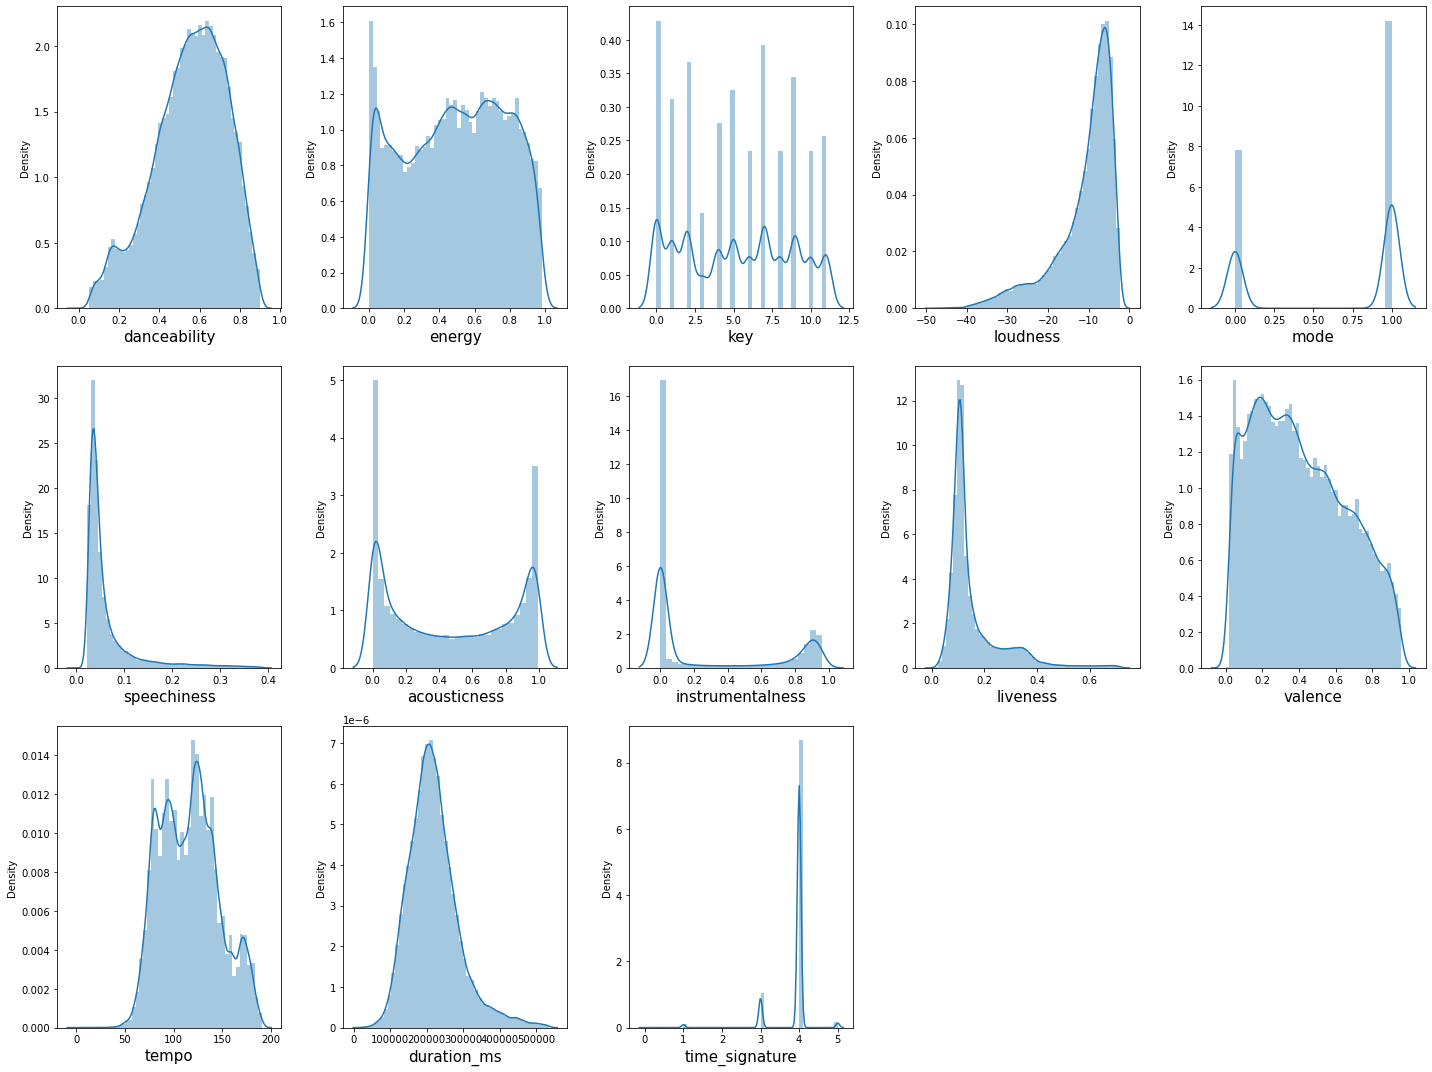

In [15]:
plt.figure(figsize=(20, 15))
plotnumber = 1
for column in df.drop(['genre'], axis=1):
    if plotnumber <= 14:
        ax = plt.subplot(3, 5, plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column, fontsize=15)

    plotnumber += 1

plt.tight_layout()
plt.show()


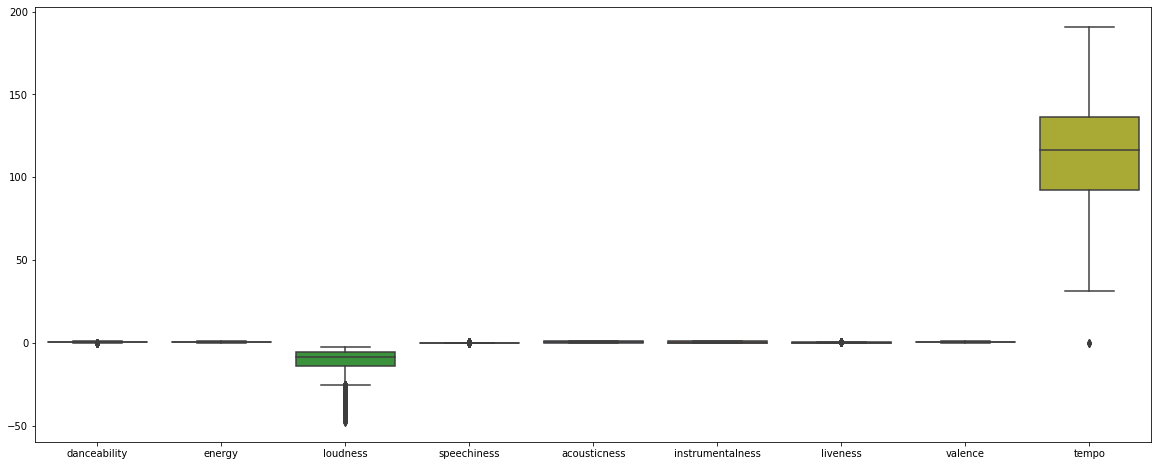

In [16]:
plt.figure(figsize=(20, 8))
sns.boxplot(data=df.drop(['duration_ms'], axis=1), width=0.8)
plt.show()


In [17]:
from scipy.stats import norm, skew  # for some statistics
cat_cols = ['genre', 'key', 'mode', 'time_signature']
# Find the skewed  numerical features
skew_features = df.drop(cat_cols, axis=1).apply(
    lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index
print("There are {} numerical features with Skew > 0.5 :".format(
    high_skew.shape[0]))
skewness = pd.DataFrame({'Skew': high_skew})
skew_features.head(10)


There are 4 numerical features with Skew > 0.5 :


speechiness         2.858719
liveness            2.237776
duration_ms         0.995768
instrumentalness    0.816415
valence             0.340169
tempo               0.273214
acousticness        0.087626
energy             -0.106477
danceability       -0.470793
loudness           -1.520641
dtype: float64

In [18]:
# from scipy.special import boxcox1p
# from scipy.stats import boxcox_normmax
# for i in skew_index:
#     df[i] = boxcox1p(df[i], boxcox_normmax(df[i] + 1))


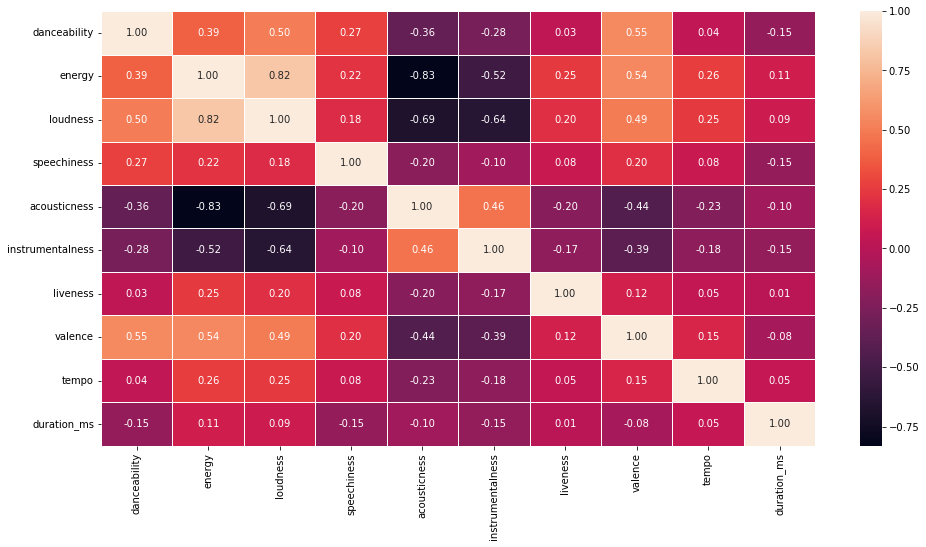

In [19]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(df.corr(), annot=True, fmt='1.2f',
            annot_kws={'size': 10}, linewidth=1)
plt.show()


# Data preparation

In [10]:
from sklearn.utils import shuffle
df = shuffle(df)


In [11]:
df = pd.get_dummies(df, columns=['key', 'mode', 'time_signature'])
df


,genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,...,key_9,key_10,key_11,mode_0,mode_1,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
3704,Alternative,0.472,0.74500,-5.297,0.0356,0.000607,0.000027,0.0957,0.0631,180.060,...,0,0,0,0,1,0,0,0,1,0
61447,K-Pop,0.706,0.61000,-3.988,0.0458,0.766000,0.000000,0.1180,0.3810,93.087,...,0,0,1,1,0,0,0,0,1,0
68110,Latin,0.838,0.70600,-6.021,0.0477,0.356000,0.000003,0.1050,0.6170,130.001,...,0,0,0,0,1,0,0,0,1,0
12185,Classical,0.440,0.05420,-25.741,0.0412,0.994000,0.935000,0.0928,0.1270,55.133,...,0,1,0,0,1,0,0,1,0,0
67404,Latin,0.810,0.79500,-5.314,0.1080,0.046800,0.000047,0.0446,0.8360,93.012,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25798,Folk & Acoustic,0.644,0.69600,-6.893,0.0256,0.616000,0.000001,0.1800,0.6020,111.939,...,0,0,0,0,1,0,0,0,1,0
8263,Blues,0.472,0.34300,-12.063,0.0574,0.511000,0.001900,0.1240,0.5840,190.936,...,0,0,0,0,1,0,0,1,0,0
32182,Indie,0.493,0.24700,-14.955,0.0323,0.980000,0.000463,0.0995,0.1730,155.778,...,0,0,0,1,0,0,0,0,1,0
41800,Instrumental,0.149,0.00184,-39.496,0.0510,0.987000,0.708000,0.1100,0.0397,137.077,...,0,0,0,0,1,0,0,0,0,1


In [12]:
X = df.drop(['genre', 'energy', 'loudness'], axis=1)
y = df[['genre']]
cols = X.columns


In [13]:
X


,danceability,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,key_0,key_1,...,key_9,key_10,key_11,mode_0,mode_1,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
46240,0.815,0.0708,0.91700,0.808000,0.3680,0.8620,87.015,104828,0,1,...,0,0,0,1,0,0,0,0,1,0
55447,0.640,0.1300,0.00738,0.002020,0.0746,0.5660,172.870,181263,0,0,...,0,0,0,0,1,0,0,0,1,0
11075,0.636,0.0624,0.54500,0.000000,0.0835,0.8850,165.992,230187,0,0,...,1,0,0,0,1,0,0,0,1,0
26674,0.653,0.0458,0.87500,0.000013,0.1990,0.6840,80.646,193267,1,0,...,0,0,0,0,1,0,0,0,1,0
55673,0.663,0.0338,0.25500,0.000000,0.1060,0.5170,120.046,180500,1,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53316,0.486,0.0465,0.94100,0.933000,0.0981,0.0819,117.445,233400,0,0,...,0,1,0,1,0,0,0,0,1,0
28718,0.521,0.0563,0.34300,0.000000,0.5880,0.5890,76.475,190980,0,0,...,1,0,0,1,0,0,0,0,1,0
49119,0.721,0.0976,0.22000,0.851000,0.0607,0.6460,87.043,144538,0,0,...,0,0,0,1,0,0,0,0,1,0
11018,0.461,0.0437,0.79400,0.000004,0.1120,0.1770,133.896,260400,0,0,...,0,0,0,0,1,0,0,0,1,0


In [13]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, accuracy_score, log_loss, classification_report


def evaluation_score(y_true, y_pred_label,y_pred_prob):
    print("accuracy score: ", accuracy_score(
        y_true, y_pred_label))
    print("f1_score: ", f1_score(y_true,
          y_pred_label, average="weighted"))
    print("precison_score: ", precision_score(
        y_true, y_pred_label, average="weighted"))
    print("recall_score: ", recall_score(
        y_true, y_pred_label, average="weighted"))
    #print("roc_auc_score: ", roc_auc_score( y_test_dum.to_numpy(), y_pred_label))
    #log loss
    print('Logarithmic Loss: ', log_loss(y_true, y_pred_prob))
    # AUC score
    print('ROC AUC score: ', roc_auc_score(y_true, y_pred_label))
    print('Classification: ', classification_report(y_true, y_pred_label))


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
sc = MinMaxScaler(feature_range=(0, 100))
X = sc.fit_transform(X)
import joblib
joblib.dump(sc, "Genre Prediction Data Preprocess.joblib")

['Genre Prediction Data Preprocess.joblib']

In [16]:
# checking for multicollinearity using `VIF` and `correlation matrix`
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif['Features'] = cols
vif


,VIF,Features
0,1.657911,danceability
1,1.129674,speechiness
2,1.591176,acousticness
3,1.415231,instrumentalness
4,1.062434,liveness
5,1.682178,valence
6,1.084414,tempo
7,1.109807,duration_ms
8,inf,key_0
9,inf,key_1


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [16]:
y_train_dum = pd.get_dummies(y_train)
y_test_dum = pd.get_dummies(y_test)


In [17]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()

# encoding train labels 
encoder.fit(y_train)
Y_train = encoder.transform(y_train)
encoder.fit(y_test)
Y_test = encoder.transform(y_test)

# XGBoost

## OVR

In [27]:
from xgboost import XGBClassifier
xgb_ovr = OneVsRestClassifier(XGBClassifier())
xgb_ovr.fit(X_train, y_train_dum)
y_pred_xgb_ovr=xgb_ovr.predict(X_test)
y_pred_xgb_ovr_prob=xgb_ovr.predict_proba(X_test)
evaluation_score(y_test_dum, y_pred_xgb_ovr, y_pred_xgb_ovr_prob)

accuracy score:  0.24916943521594684
f1_score:  0.2982947609192188
precison_score:  0.4734506418117189
recall_score:  0.2562048075043971
Logarithmic Loss:  1.8630033550314442
ROC AUC score:  0.5767094937839107
Classification:                precision    recall  f1-score   support

           0       0.03      0.00      0.00       469
           1       0.58      0.12      0.20       685
           2       0.26      0.01      0.03       605
           3       0.62      0.37      0.46       749
           4       0.80      0.51      0.63       742
           5       0.48      0.06      0.10       996
           6       0.60      0.20      0.30       509
           7       0.09      0.00      0.01       826
           8       0.74      0.76      0.75      2916
           9       0.32      0.09      0.14       731
          10       0.55      0.19      0.28      1727
          11       0.58      0.15      0.24       883
          12       0.39      0.03      0.06       317
          13    

## Binary Relevance

In [34]:
xgb_br = BinaryRelevance(XGBClassifier())
xgb_br.fit(X_train, y_train_dum)
y_pred_xgb_br=xgb_br.predict(X_test)
y_pred_xgb_br_prob=xgb_br.predict_proba(X_test)
evaluation_score(y_test_dum, y_pred_xgb_br.toarray(), y_pred_xgb_br_prob.toarray())

accuracy score:  0.24916943521594684
f1_score:  0.2982947609192188
precison_score:  0.4734506418117189
recall_score:  0.2562048075043971
Logarithmic Loss:  1.863003354787659
ROC AUC score:  0.5767094937839107
Classification:                precision    recall  f1-score   support

           0       0.03      0.00      0.00       469
           1       0.58      0.12      0.20       685
           2       0.26      0.01      0.03       605
           3       0.62      0.37      0.46       749
           4       0.80      0.51      0.63       742
           5       0.48      0.06      0.10       996
           6       0.60      0.20      0.30       509
           7       0.09      0.00      0.01       826
           8       0.74      0.76      0.75      2916
           9       0.32      0.09      0.14       731
          10       0.55      0.19      0.28      1727
          11       0.58      0.15      0.24       883
          12       0.39      0.03      0.06       317
          13     

## Classifier Chain

In [35]:
xgb_cc = ClassifierChain(XGBClassifier())
xgb_cc.fit(X_train, y_train_dum)
y_pred_xgb_cc=xgb_cc.predict(X_test)
y_pred_xgb_cc_prob=xgb_cc.predict_proba(X_test)
evaluation_score(y_test_dum, y_pred_xgb_cc.toarray(), y_pred_xgb_cc_prob.toarray())

accuracy score:  0.37274444661585565
f1_score:  0.3640445222155112
precison_score:  0.44423664415590985
recall_score:  0.37274444661585565
Logarithmic Loss:  2.5395238119096235
ROC AUC score:  0.6268519421719067
Classification:                precision    recall  f1-score   support

           0       0.03      0.00      0.00       469
           1       0.55      0.14      0.23       685
           2       0.48      0.02      0.04       605
           3       0.61      0.38      0.47       749
           4       0.78      0.52      0.62       742
           5       0.51      0.12      0.19       996
           6       0.57      0.20      0.30       509
           7       0.18      0.02      0.04       826
           8       0.69      0.83      0.75      2916
           9       0.31      0.26      0.28       731
          10       0.46      0.33      0.39      1727
          11       0.45      0.32      0.37       883
          12       0.26      0.06      0.10       317
          13  

## Label Powerset

In [36]:
xgb_lp = LabelPowerset(XGBClassifier())
xgb_lp.fit(X_train, y_train_dum)
y_pred_xgb_lp=xgb_lp.predict(X_test)
y_pred_xgb_lp_prob=xgb_lp.predict_proba(X_test)
evaluation_score(y_test_dum, y_pred_xgb_lp.toarray(), y_pred_xgb_lp_prob.toarray())

accuracy score:  0.42427203439515343
f1_score:  0.3999141581405259
precison_score:  0.39033010446185284
recall_score:  0.42427203439515343
Logarithmic Loss:  1.8163682681158368
ROC AUC score:  0.6416436305029928
Classification:                precision    recall  f1-score   support

           0       0.09      0.05      0.07       469
           1       0.35      0.35      0.35       685
           2       0.27      0.19      0.22       605
           3       0.60      0.45      0.52       749
           4       0.61      0.66      0.63       742
           5       0.32      0.43      0.37       996
           6       0.44      0.36      0.40       509
           7       0.13      0.10      0.11       826
           8       0.68      0.83      0.75      2916
           9       0.32      0.24      0.28       731
          10       0.37      0.56      0.45      1727
          11       0.37      0.37      0.37       883
          12       0.24      0.12      0.16       317
          13  

## Tuning

In [43]:
print(LabelPowerset(classifier=XGBClassifier(random_state=0)).get_params().keys())

dict_keys(['classifier', 'classifier__objective', 'classifier__use_label_encoder', 'classifier__base_score', 'classifier__booster', 'classifier__callbacks', 'classifier__colsample_bylevel', 'classifier__colsample_bynode', 'classifier__colsample_bytree', 'classifier__early_stopping_rounds', 'classifier__enable_categorical', 'classifier__eval_metric', 'classifier__feature_types', 'classifier__gamma', 'classifier__gpu_id', 'classifier__grow_policy', 'classifier__importance_type', 'classifier__interaction_constraints', 'classifier__learning_rate', 'classifier__max_bin', 'classifier__max_cat_threshold', 'classifier__max_cat_to_onehot', 'classifier__max_delta_step', 'classifier__max_depth', 'classifier__max_leaves', 'classifier__min_child_weight', 'classifier__missing', 'classifier__monotone_constraints', 'classifier__n_estimators', 'classifier__n_jobs', 'classifier__num_parallel_tree', 'classifier__predictor', 'classifier__random_state', 'classifier__reg_alpha', 'classifier__reg_lambda', 'c

### max depth, min child weight

In [45]:
param_test1 = {
 'classifier__max_depth':range(4,10,2),
 'classifier__min_child_weight':range(1,6,2)
}

xgb_tuned1 = LabelPowerset(XGBClassifier(random_state=0))
gsearch1 = GridSearchCV(estimator=xgb_tuned1, param_grid=param_test1, scoring='f1_weighted', cv=5, verbose=3)
gsearch1.fit(X_train, y_train_dum)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END classifier__max_depth=4, classifier__min_child_weight=1;, score=0.409 total time=  48.6s
[CV 2/5] END classifier__max_depth=4, classifier__min_child_weight=1;, score=0.393 total time=  50.2s
[CV 3/5] END classifier__max_depth=4, classifier__min_child_weight=1;, score=0.397 total time=  53.8s
[CV 4/5] END classifier__max_depth=4, classifier__min_child_weight=1;, score=0.410 total time=  57.6s
[CV 5/5] END classifier__max_depth=4, classifier__min_child_weight=1;, score=0.395 total time=  53.8s
[CV 1/5] END classifier__max_depth=4, classifier__min_child_weight=3;, score=0.404 total time=  47.2s
[CV 2/5] END classifier__max_depth=4, classifier__min_child_weight=3;, score=0.393 total time=  46.2s
[CV 3/5] END classifier__max_depth=4, classifier__min_child_weight=3;, score=0.400 total time=  45.2s
[CV 4/5] END classifier__max_depth=4, classifier__min_child_weight=3;, score=0.407 total time=  45.2s
[CV 5/5] END classifie

GridSearchCV(cv=5,
             estimator=LabelPowerset(classifier=XGBClassifier(base_score=None,
                                                              booster=None,
                                                              callbacks=None,
                                                              colsample_bylevel=None,
                                                              colsample_bynode=None,
                                                              colsample_bytree=None,
                                                              early_stopping_rounds=None,
                                                              enable_categorical=False,
                                                              eval_metric=None,
                                                              feature_types=None,
                                                              gamma=None,
                                                              gpu_id=None,
                                                              grow_policy=None,
                                                              importance_type=None,
                                                              interaction_constraints...
                                                              max_delta_step=None,
                                                              max_depth=None,
                                                              max_leaves=None,
                                                              min_child_weight=None,
                                                              missing=nan,
                                                              monotone_constraints=None,
                                                              n_estimators=100,
                                                              n_jobs=None,
                                                              num_parallel_tree=None,
                                                              predictor=None,
                                                              random_state=0, ...),
                                     require_dense=[True, True]),
             param_grid={'classifier__max_depth': range(4, 10, 2),
                         'classifier__min_child_weight': range(1, 6, 2)},
             scoring='f1_weighted', verbose=3)

In [46]:
gsearch1.best_params_

{'classifier__max_depth': 4, 'classifier__min_child_weight': 5}

### Gamma

In [47]:
param_test2 = {
 'classifier__gamma':[i/10.0 for i in range(0,5)]
}

xgb_tuned2 = LabelPowerset(XGBClassifier(random_state=0, max_depth=4, min_child_weight=5))
gsearch2 = GridSearchCV(estimator=xgb_tuned2, param_grid=param_test2, scoring='f1_weighted', cv=5, verbose=3)
gsearch2.fit(X_train, y_train_dum)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .............classifier__gamma=0.0;, score=0.406 total time=  49.9s
[CV 2/5] END .............classifier__gamma=0.0;, score=0.392 total time=  47.3s
[CV 3/5] END .............classifier__gamma=0.0;, score=0.401 total time=  47.1s
[CV 4/5] END .............classifier__gamma=0.0;, score=0.408 total time=  46.8s
[CV 5/5] END .............classifier__gamma=0.0;, score=0.398 total time=  47.1s
[CV 1/5] END .............classifier__gamma=0.1;, score=0.405 total time=  46.8s
[CV 2/5] END .............classifier__gamma=0.1;, score=0.391 total time=  47.0s
[CV 3/5] END .............classifier__gamma=0.1;, score=0.397 total time=  46.9s
[CV 4/5] END .............classifier__gamma=0.1;, score=0.408 total time=  46.7s
[CV 5/5] END .............classifier__gamma=0.1;, score=0.398 total time=  49.2s
[CV 1/5] END .............classifier__gamma=0.2;, score=0.404 total time=  47.2s
[CV 2/5] END .............classifier__gamma=0.2;,

GridSearchCV(cv=5,
             estimator=LabelPowerset(classifier=XGBClassifier(base_score=None,
                                                              booster=None,
                                                              callbacks=None,
                                                              colsample_bylevel=None,
                                                              colsample_bynode=None,
                                                              colsample_bytree=None,
                                                              early_stopping_rounds=None,
                                                              enable_categorical=False,
                                                              eval_metric=None,
                                                              feature_types=None,
                                                              gamma=None,
                                                              gpu_id=None,
                                                              grow_policy=None,
                                                              importance_type=None,
                                                              interaction_constraints...
                                                              max_cat_threshold=None,
                                                              max_cat_to_onehot=None,
                                                              max_delta_step=None,
                                                              max_depth=4,
                                                              max_leaves=None,
                                                              min_child_weight=5,
                                                              missing=nan,
                                                              monotone_constraints=None,
                                                              n_estimators=100,
                                                              n_jobs=None,
                                                              num_parallel_tree=None,
                                                              predictor=None,
                                                              random_state=0, ...),
                                     require_dense=[True, True]),
             param_grid={'classifier__gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             scoring='f1_weighted', verbose=3)

In [48]:
gsearch2.best_params_

{'classifier__gamma': 0.3}

### subsample, colsample_bytree

In [49]:
param_test3 = {
 'classifier__subsample':[i/100.0 for i in range(70,105,10)],
 'classifier__colsample_bytree':[i/100.0 for i in range(70,105,10)]
}

xgb_tuned3 = LabelPowerset(XGBClassifier(random_state=0,  max_depth=4, min_child_weight=5, gamma=0.3))
gsearch3 = GridSearchCV(estimator=xgb_tuned3, param_grid=param_test3, scoring='f1_weighted', cv=5, verbose=3)
gsearch3.fit(X_train, y_train_dum)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END classifier__colsample_bytree=0.7, classifier__subsample=0.7;, score=0.405 total time=  41.2s
[CV 2/5] END classifier__colsample_bytree=0.7, classifier__subsample=0.7;, score=0.396 total time=  36.2s
[CV 3/5] END classifier__colsample_bytree=0.7, classifier__subsample=0.7;, score=0.403 total time=  36.7s
[CV 4/5] END classifier__colsample_bytree=0.7, classifier__subsample=0.7;, score=0.409 total time=  35.3s
[CV 5/5] END classifier__colsample_bytree=0.7, classifier__subsample=0.7;, score=0.401 total time=  35.2s
[CV 1/5] END classifier__colsample_bytree=0.7, classifier__subsample=0.8;, score=0.403 total time=  35.0s
[CV 2/5] END classifier__colsample_bytree=0.7, classifier__subsample=0.8;, score=0.399 total time=  35.9s
[CV 3/5] END classifier__colsample_bytree=0.7, classifier__subsample=0.8;, score=0.403 total time=  35.8s
[CV 4/5] END classifier__colsample_bytree=0.7, classifier__subsample=0.8;, score=0.405 tota

GridSearchCV(cv=5,
             estimator=LabelPowerset(classifier=XGBClassifier(base_score=None,
                                                              booster=None,
                                                              callbacks=None,
                                                              colsample_bylevel=None,
                                                              colsample_bynode=None,
                                                              colsample_bytree=None,
                                                              early_stopping_rounds=None,
                                                              enable_categorical=False,
                                                              eval_metric=None,
                                                              feature_types=None,
                                                              gamma=0.3,
                                                              gpu_id=None,
                                                              grow_policy=None,
                                                              importance_type=None,
                                                              interaction_constraints=...
                                                              max_delta_step=None,
                                                              max_depth=4,
                                                              max_leaves=None,
                                                              min_child_weight=5,
                                                              missing=nan,
                                                              monotone_constraints=None,
                                                              n_estimators=100,
                                                              n_jobs=None,
                                                              num_parallel_tree=None,
                                                              predictor=None,
                                                              random_state=0, ...),
                                     require_dense=[True, True]),
             param_grid={'classifier__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
                         'classifier__subsample': [0.7, 0.8, 0.9, 1.0]},
             scoring='f1_weighted', verbose=3)

In [50]:
gsearch3.best_params_

{'classifier__colsample_bytree': 0.9, 'classifier__subsample': 0.7}

### Learning Rate & n_estimators

In [53]:
param_test4 = {
 'classifier__n_estimators':[200, 250, 500],
 'classifier__learning_rate':[0.01, 0.1, 0.001]
}

xgb_tuned4 = LabelPowerset(XGBClassifier(random_state=0,  max_depth=4, min_child_weight=5, gamma=0.3, subsample = 0.7, colsample_bytree=0.9))
gsearch4 = GridSearchCV(estimator=xgb_tuned4, param_grid=param_test4, scoring='f1_weighted', cv=5, verbose=3)
gsearch4.fit(X_train, y_train_dum)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END classifier__learning_rate=0.01, classifier__n_estimators=200;, score=0.369 total time= 1.3min
[CV 2/5] END classifier__learning_rate=0.01, classifier__n_estimators=200;, score=0.358 total time= 1.3min
[CV 3/5] END classifier__learning_rate=0.01, classifier__n_estimators=200;, score=0.361 total time= 1.3min
[CV 4/5] END classifier__learning_rate=0.01, classifier__n_estimators=200;, score=0.372 total time= 1.3min
[CV 5/5] END classifier__learning_rate=0.01, classifier__n_estimators=200;, score=0.364 total time= 1.3min
[CV 1/5] END classifier__learning_rate=0.01, classifier__n_estimators=250;, score=0.373 total time= 1.6min
[CV 2/5] END classifier__learning_rate=0.01, classifier__n_estimators=250;, score=0.363 total time= 1.6min
[CV 3/5] END classifier__learning_rate=0.01, classifier__n_estimators=250;, score=0.366 total time= 1.6min
[CV 4/5] END classifier__learning_rate=0.01, classifier__n_estimators=250;, score=0.

GridSearchCV(cv=5,
             estimator=LabelPowerset(classifier=XGBClassifier(base_score=None,
                                                              booster=None,
                                                              callbacks=None,
                                                              colsample_bylevel=None,
                                                              colsample_bynode=None,
                                                              colsample_bytree=0.9,
                                                              early_stopping_rounds=None,
                                                              enable_categorical=False,
                                                              eval_metric=None,
                                                              feature_types=None,
                                                              gamma=0.3,
                                                              gpu_id=None,
                                                              grow_policy=None,
                                                              importance_type=None,
                                                              interaction_constraints=N...
                                                              max_delta_step=None,
                                                              max_depth=4,
                                                              max_leaves=None,
                                                              min_child_weight=5,
                                                              missing=nan,
                                                              monotone_constraints=None,
                                                              n_estimators=100,
                                                              n_jobs=None,
                                                              num_parallel_tree=None,
                                                              predictor=None,
                                                              random_state=0, ...),
                                     require_dense=[True, True]),
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.001],
                         'classifier__n_estimators': [200, 250, 500]},
             scoring='f1_weighted', verbose=3)

In [54]:
gsearch4.best_params_

{'classifier__learning_rate': 0.1, 'classifier__n_estimators': 250}

### Tuned XGB

In [19]:
from xgboost import XGBClassifier
xgb = LabelPowerset(XGBClassifier(learning_rate = 0.1, n_estimators = 250,random_state=0,  max_depth=4, min_child_weight=5, gamma=0.3, subsample = 0.7, colsample_bytree=0.9))

xgb.fit(X_train, y_train_dum)
y_pred_xgb=xgb.predict(X_test)
y_pred_xgb_prob=xgb.predict_proba(X_test)
evaluation_score(y_test_dum, y_pred_xgb.toarray(), y_pred_xgb_prob.toarray())

accuracy score:  0.4359325125398997
f1_score:  0.4040657277943311
precison_score:  0.39873854885590515
recall_score:  0.4359325125398997
Logarithmic Loss:  1.7719096709895974
ROC AUC score:  0.64555305596267
Classification:                precision    recall  f1-score   support

           0       0.15      0.04      0.07       513
           1       0.34      0.34      0.34       695
           2       0.27      0.17      0.21       555
           3       0.64      0.47      0.54       784
           4       0.58      0.66      0.61       720
           5       0.30      0.44      0.36      1000
           6       0.42      0.35      0.38       541
           7       0.20      0.12      0.15       884
           8       0.68      0.86      0.76      2948
           9       0.33      0.24      0.28       715
          10       0.36      0.59      0.45      1718
          11       0.35      0.35      0.35       895
          12       0.29      0.12      0.17       303
          13      

In [20]:
import joblib
joblib.dump(xgb, 'Genre Prediction Model.sav')

['Genre Prediction Model.sav']

# LightGBM

In [56]:
from lightgbm import LGBMClassifier

lgbm = LabelPowerset(LGBMClassifier())
lgbm.fit(X_train, y_train_dum)
y_pred_lgbm=lgbm.predict(X_test)
y_pred_lgbm_prob=lgbm.predict_proba(X_test)
evaluation_score(y_test_dum, y_pred_lgbm.toarray(), y_pred_lgbm_prob.toarray())

accuracy score:  0.4270080125073285
f1_score:  0.4016603214226537
precison_score:  0.39140639791471005
recall_score:  0.4270080125073285
Logarithmic Loss:  1.8022158819480874
ROC AUC score:  0.6425707411611125
Classification:                precision    recall  f1-score   support

           0       0.11      0.05      0.07       469
           1       0.33      0.33      0.33       685
           2       0.29      0.21      0.24       605
           3       0.59      0.45      0.51       749
           4       0.62      0.67      0.64       742
           5       0.31      0.42      0.36       996
           6       0.45      0.38      0.42       509
           7       0.16      0.11      0.13       826
           8       0.68      0.84      0.75      2916
           9       0.35      0.25      0.29       731
          10       0.37      0.57      0.45      1727
          11       0.38      0.38      0.38       883
          12       0.19      0.11      0.14       317
          13    

### Tune n_estimators

In [158]:
param_test = {'classifier__n_estimators':[60,100,150,200,500]}

lgbm_tuned = LabelPowerset(LGBMClassifier(random_state=0))
gsearch = GridSearchCV(estimator=lgbm_tuned, param_grid=param_test, scoring='f1_weighted', cv=5, verbose=3)

gsearch.fit(X_train, y_train_dum)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .......classifier__n_estimators=60;, score=0.405 total time=   4.1s
[CV 2/5] END .......classifier__n_estimators=60;, score=0.392 total time=   4.1s
[CV 3/5] END .......classifier__n_estimators=60;, score=0.397 total time=   3.8s
[CV 4/5] END .......classifier__n_estimators=60;, score=0.410 total time=   4.4s
[CV 5/5] END .......classifier__n_estimators=60;, score=0.402 total time=   4.0s
[CV 1/5] END ......classifier__n_estimators=100;, score=0.399 total time=   6.3s
[CV 2/5] END ......classifier__n_estimators=100;, score=0.390 total time=   7.2s
[CV 3/5] END ......classifier__n_estimators=100;, score=0.394 total time=   7.5s
[CV 4/5] END ......classifier__n_estimators=100;, score=0.404 total time=   7.0s
[CV 5/5] END ......classifier__n_estimators=100;, score=0.399 total time=   6.8s
[CV 1/5] END ......classifier__n_estimators=150;, score=0.395 total time=   8.5s
[CV 2/5] END ......classifier__n_estimators=150;,

GridSearchCV(cv=5,
             estimator=LabelPowerset(classifier=LGBMClassifier(random_state=0),
                                     require_dense=[True, True]),
             param_grid={'classifier__n_estimators': [60, 100, 150, 200, 500]},
             scoring='f1_weighted', verbose=3)

In [159]:
gsearch.best_params_

{'classifier__n_estimators': 60}

### Tune max_depth & min_samples_split

In [59]:
param_test = {'classifier__max_depth':range(4,10,2), 'classifier__min_split_gain':np.arange(0,0.4,0.1)}
lgbm_tuned = LabelPowerset(LGBMClassifier(random_state=0, n_estimators=60))

gsearch = GridSearchCV(estimator=lgbm_tuned, param_grid=param_test, scoring='f1_weighted', cv=5, verbose=3)
gsearch.fit(X_train, y_train_dum)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END classifier__max_depth=4, classifier__min_split_gain=0.0;, score=0.399 total time=   3.4s
[CV 2/5] END classifier__max_depth=4, classifier__min_split_gain=0.0;, score=0.387 total time=   3.0s
[CV 3/5] END classifier__max_depth=4, classifier__min_split_gain=0.0;, score=0.397 total time=   2.6s
[CV 4/5] END classifier__max_depth=4, classifier__min_split_gain=0.0;, score=0.402 total time=   3.2s
[CV 5/5] END classifier__max_depth=4, classifier__min_split_gain=0.0;, score=0.392 total time=   3.2s
[CV 1/5] END classifier__max_depth=4, classifier__min_split_gain=0.1;, score=0.399 total time=   3.0s
[CV 2/5] END classifier__max_depth=4, classifier__min_split_gain=0.1;, score=0.387 total time=   2.7s
[CV 3/5] END classifier__max_depth=4, classifier__min_split_gain=0.1;, score=0.394 total time=   2.5s
[CV 4/5] END classifier__max_depth=4, classifier__min_split_gain=0.1;, score=0.403 total time=   2.4s
[CV 5/5] END classifi

GridSearchCV(cv=5,
             estimator=LabelPowerset(classifier=LGBMClassifier(n_estimators=60,
                                                               random_state=0),
                                     require_dense=[True, True]),
             param_grid={'classifier__max_depth': range(4, 10, 2),
                         'classifier__min_split_gain': array([0. , 0.1, 0.2, 0.3])},
             scoring='f1_weighted', verbose=3)

In [60]:
gsearch.best_params_

{'classifier__max_depth': 6, 'classifier__min_split_gain': 0.30000000000000004}

### Tune min_child_samples

In [61]:
param_test = {'classifier__min_child_samples': range(20,71,10)}
lgbm_tuned = LabelPowerset(LGBMClassifier(random_state=0, n_estimators=60,max_depth=6,min_split_gain=0.3))

gsearch = GridSearchCV(estimator=lgbm_tuned, param_grid=param_test, scoring='f1_weighted', cv=5, verbose=3)
gsearch.fit(X_train, y_train_dum)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ..classifier__min_child_samples=20;, score=0.404 total time=   4.7s
[CV 2/5] END ..classifier__min_child_samples=20;, score=0.395 total time=   5.0s
[CV 3/5] END ..classifier__min_child_samples=20;, score=0.400 total time=   7.2s
[CV 4/5] END ..classifier__min_child_samples=20;, score=0.411 total time=   9.4s
[CV 5/5] END ..classifier__min_child_samples=20;, score=0.401 total time=   5.1s
[CV 1/5] END ..classifier__min_child_samples=30;, score=0.404 total time=   3.7s
[CV 2/5] END ..classifier__min_child_samples=30;, score=0.393 total time=   3.5s
[CV 3/5] END ..classifier__min_child_samples=30;, score=0.400 total time=   3.4s
[CV 4/5] END ..classifier__min_child_samples=30;, score=0.411 total time=   3.6s
[CV 5/5] END ..classifier__min_child_samples=30;, score=0.398 total time=   3.5s
[CV 1/5] END ..classifier__min_child_samples=40;, score=0.407 total time=   3.5s
[CV 2/5] END ..classifier__min_child_samples=40;,

GridSearchCV(cv=5,
             estimator=LabelPowerset(classifier=LGBMClassifier(max_depth=6,
                                                               min_split_gain=0.3,
                                                               n_estimators=60,
                                                               random_state=0),
                                     require_dense=[True, True]),
             param_grid={'classifier__min_child_samples': range(20, 71, 10)},
             scoring='f1_weighted', verbose=3)

In [62]:
gsearch.best_params_

{'classifier__min_child_samples': 70}

### Tune subsample

In [63]:
param_test = {
 'classifier__subsample':[0.6,0.7,0.75,0.8,0.85,0.9]
}

lgbm_tuned = LabelPowerset(LGBMClassifier(random_state=0,  n_estimators=60,max_depth=6,min_split_gain=0.3,min_child_samples=70))

gsearch = GridSearchCV(estimator=lgbm_tuned, param_grid=param_test, scoring='f1_weighted', cv=5, verbose=3)
gsearch.fit(X_train, y_train_dum)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .........classifier__subsample=0.6;, score=0.407 total time=   5.2s
[CV 2/5] END .........classifier__subsample=0.6;, score=0.394 total time=   5.4s
[CV 3/5] END .........classifier__subsample=0.6;, score=0.403 total time=  11.5s
[CV 4/5] END .........classifier__subsample=0.6;, score=0.410 total time=   4.4s
[CV 5/5] END .........classifier__subsample=0.6;, score=0.402 total time=   4.6s
[CV 1/5] END .........classifier__subsample=0.7;, score=0.407 total time=   4.7s
[CV 2/5] END .........classifier__subsample=0.7;, score=0.394 total time=   4.0s
[CV 3/5] END .........classifier__subsample=0.7;, score=0.403 total time=   4.5s
[CV 4/5] END .........classifier__subsample=0.7;, score=0.410 total time=   4.8s
[CV 5/5] END .........classifier__subsample=0.7;, score=0.402 total time=   4.0s
[CV 1/5] END ........classifier__subsample=0.75;, score=0.407 total time=   3.7s
[CV 2/5] END ........classifier__subsample=0.75;,

GridSearchCV(cv=5,
             estimator=LabelPowerset(classifier=LGBMClassifier(max_depth=6,
                                                               min_child_samples=70,
                                                               min_split_gain=0.3,
                                                               n_estimators=60,
                                                               random_state=0),
                                     require_dense=[True, True]),
             param_grid={'classifier__subsample': [0.6, 0.7, 0.75, 0.8, 0.85,
                                                   0.9]},
             scoring='f1_weighted', verbose=3)

In [64]:
gsearch.best_params_

{'classifier__subsample': 0.6}

### Tune learning rate

In [65]:
param_test = {
 'classifier__learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5]
}

lgbm_tuned = LabelPowerset(LGBMClassifier(random_state=0, n_estimators=60,max_depth=6,min_split_gain=0.3,min_child_samples=70,subsample=0.6))

gsearch = GridSearchCV(estimator=lgbm_tuned, param_grid=param_test, scoring='f1_weighted', cv=5, verbose=3)
gsearch.fit(X_train, y_train_dum)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .....classifier__learning_rate=0.1;, score=0.407 total time=   3.7s
[CV 2/5] END .....classifier__learning_rate=0.1;, score=0.394 total time=   3.4s
[CV 3/5] END .....classifier__learning_rate=0.1;, score=0.403 total time=   4.2s
[CV 4/5] END .....classifier__learning_rate=0.1;, score=0.410 total time=   3.3s
[CV 5/5] END .....classifier__learning_rate=0.1;, score=0.402 total time=   3.5s
[CV 1/5] END .....classifier__learning_rate=0.2;, score=0.399 total time=   3.5s
[CV 2/5] END .....classifier__learning_rate=0.2;, score=0.390 total time=   3.5s
[CV 3/5] END .....classifier__learning_rate=0.2;, score=0.392 total time=   3.8s
[CV 4/5] END .....classifier__learning_rate=0.2;, score=0.401 total time=   3.2s
[CV 5/5] END .....classifier__learning_rate=0.2;, score=0.395 total time=   4.0s
[CV 1/5] END .....classifier__learning_rate=0.3;, score=0.388 total time=   4.3s
[CV 2/5] END .....classifier__learning_rate=0.3;,

GridSearchCV(cv=5,
             estimator=LabelPowerset(classifier=LGBMClassifier(max_depth=6,
                                                               min_child_samples=70,
                                                               min_split_gain=0.3,
                                                               n_estimators=60,
                                                               random_state=0,
                                                               subsample=0.6),
                                     require_dense=[True, True]),
             param_grid={'classifier__learning_rate': [0.1, 0.2, 0.3, 0.4,
                                                       0.5]},
             scoring='f1_weighted', verbose=3)

In [66]:
gsearch.best_params_

{'classifier__learning_rate': 0.1}

### Tuned LGBM

In [70]:
from lightgbm import LGBMClassifier
lgbm = LabelPowerset(LGBMClassifier(n_estimators=60,max_depth=6,min_split_gain=0.3,min_child_samples=70,subsample=0.6, learning_rate=0.1))
lgbm.fit(X_train, y_train_dum)
y_pred_lgbm=lgbm.predict(X_test)
y_pred_lgbm_prob=lgbm.predict_proba(X_test)
evaluation_score(y_test_dum, y_pred_lgbm.toarray(),y_pred_lgbm_prob.toarray())

accuracy score:  0.4377564979480164
f1_score:  0.4076748400651264
precison_score:  0.4016263001649425
recall_score:  0.4377564979480164
Logarithmic Loss:  1.7750564851162203
ROC AUC score:  0.6469707211727664
Classification:                precision    recall  f1-score   support

           0       0.15      0.05      0.08       469
           1       0.35      0.34      0.34       685
           2       0.31      0.20      0.24       605
           3       0.61      0.45      0.52       749
           4       0.60      0.67      0.63       742
           5       0.30      0.45      0.36       996
           6       0.45      0.38      0.41       509
           7       0.18      0.11      0.14       826
           8       0.68      0.85      0.76      2916
           9       0.36      0.26      0.31       731
          10       0.36      0.58      0.45      1727
          11       0.40      0.39      0.39       883
          12       0.26      0.12      0.17       317
          13     

# Random Forest

In [73]:
from sklearn.ensemble import RandomForestClassifier
rf = LabelPowerset(RandomForestClassifier())
rf.fit(X_train, y_train_dum)
y_pred_rf=rf.predict(X_test)
y_pred_rf_prob=rf.predict_proba(X_test)
evaluation_score(y_test_dum, y_pred_rf.toarray(),y_pred_rf_prob.toarray())

accuracy score:  0.3950231255292815
f1_score:  0.37253436009413315
precison_score:  0.36357847777001595
recall_score:  0.3950231255292815
Logarithmic Loss:  3.1540259506816777
ROC AUC score:  0.6275699471297269
Classification:                precision    recall  f1-score   support

           0       0.05      0.03      0.04       469
           1       0.36      0.32      0.34       685
           2       0.37      0.20      0.26       605
           3       0.55      0.39      0.46       749
           4       0.60      0.62      0.61       742
           5       0.32      0.42      0.36       996
           6       0.37      0.32      0.34       509
           7       0.10      0.08      0.09       826
           8       0.64      0.78      0.70      2916
           9       0.20      0.15      0.17       731
          10       0.39      0.55      0.45      1727
          11       0.30      0.34      0.32       883
          12       0.20      0.10      0.13       317
          13   

In [75]:
rf = LabelPowerset(RandomForestClassifier())
params = {'classifier__n_estimators': [200,300,500],
          'classifier__max_depth': [10,15,20], 
         'classifier__min_samples_split' : [10,15,20],  
         'classifier__min_samples_leaf' : [2,5,10]
          }
cv_rf = GridSearchCV(rf, params, cv=5, n_jobs=-1,
                   verbose=3, scoring="f1_weighted")
cv_rf.fit(X_train, y_train_dum)
print("Best params: ", cv_rf.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END classifier__max_depth=10, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=200;, score=0.349 total time=  28.4s
[CV 4/5] END classifier__max_depth=10, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=200;, score=0.356 total time=  28.7s
[CV 3/5] END classifier__max_depth=10, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=200;, score=0.342 total time=  28.8s
[CV 2/5] END classifier__max_depth=10, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=200;, score=0.345 total time=  28.9s
[CV 5/5] END classifier__max_depth=10, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=200;, score=0.345 total time=  29.0s
[CV 1/5] END classifier__max_depth=10, classifier__min_samples_leaf=2, classifier__min_samples_split=10

In [77]:
rf = LabelPowerset(RandomForestClassifier(n_estimators=300,max_depth=20, 
                            min_samples_split = 15,  min_samples_leaf = 2))
rf.fit(X_train, y_train_dum)
y_pred_rf=rf.predict(X_test)
y_pred_rf_prob=rf.predict_proba(X_test)
evaluation_score( y_test_dum, y_pred_rf.toarray(),y_pred_rf_prob.toarray())

accuracy score:  0.42042863657090745
f1_score:  0.3822931116780067
precison_score:  0.3787106056957732
recall_score:  0.42042863657090745
Logarithmic Loss:  1.8238488651416846
ROC AUC score:  0.6326539230446336
Classification:                precision    recall  f1-score   support

           0       0.03      0.01      0.02       469
           1       0.37      0.30      0.33       685
           2       0.34      0.14      0.20       605
           3       0.61      0.39      0.48       749
           4       0.59      0.61      0.60       742
           5       0.30      0.46      0.36       996
           6       0.44      0.31      0.37       509
           7       0.14      0.10      0.12       826
           8       0.64      0.86      0.73      2916
           9       0.27      0.14      0.18       731
          10       0.35      0.63      0.45      1727
          11       0.35      0.38      0.37       883
          12       0.27      0.10      0.14       317
          13   

# KNN

In [83]:
# import KNeighbors ClaSSifier from sklearn
from sklearn.neighbors import KNeighborsClassifier

# instantiate the model
knn = LabelPowerset(KNeighborsClassifier(n_neighbors=7))
# fit the model to the training set
knn.fit(X_train, y_train_dum)
y_pred_knn=knn.predict(X_test)
y_pred_knn_prob=knn.predict_proba(X_test)
evaluation_score(y_test_dum, y_pred_knn.toarray(),y_pred_knn_prob.toarray())


accuracy score:  0.3285128004690248
f1_score:  0.3052422824175298
precison_score:  0.30289234112215885
recall_score:  0.3285128004690248
Logarithmic Loss:  13.05816166178482
ROC AUC score:  0.5880083513902621
Classification:                precision    recall  f1-score   support

           0       0.05      0.02      0.03       469
           1       0.25      0.14      0.18       685
           2       0.18      0.11      0.13       605
           3       0.47      0.28      0.36       749
           4       0.49      0.45      0.47       742
           5       0.19      0.23      0.21       996
           6       0.36      0.22      0.27       509
           7       0.10      0.11      0.10       826
           8       0.64      0.83      0.72      2916
           9       0.23      0.11      0.15       731
          10       0.25      0.36      0.29      1727
          11       0.22      0.32      0.26       883
          12       0.14      0.04      0.06       317
          13     

In [85]:
knn = LabelPowerset(KNeighborsClassifier())
params = {'classifier__n_neighbors' : [7,9,11,13,15,20,25],
               'classifier__weights' : ['uniform','distance'],
               'classifier__metric' : ['minkowski','euclidean','manhattan']
          }
cv_knn = GridSearchCV(knn, params, cv=5, n_jobs=-1,
                   verbose=3, scoring="f1_weighted")
cv_knn.fit(X_train, y_train_dum)
print("Best params: ", cv_knn.best_params_)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV 3/5] END classifier__metric=minkowski, classifier__n_neighbors=7, classifier__weights=distance;, score=0.296 total time=   9.5s
[CV 2/5] END classifier__metric=minkowski, classifier__n_neighbors=7, classifier__weights=distance;, score=0.290 total time=   9.6s
[CV 1/5] END classifier__metric=minkowski, classifier__n_neighbors=7, classifier__weights=distance;, score=0.296 total time=   9.6s
[CV 1/5] END classifier__metric=minkowski, classifier__n_neighbors=7, classifier__weights=uniform;, score=0.305 total time=  10.3s
[CV 3/5] END classifier__metric=minkowski, classifier__n_neighbors=7, classifier__weights=uniform;, score=0.302 total time=  10.3s
[CV 5/5] END classifier__metric=minkowski, classifier__n_neighbors=7, classifier__weights=uniform;, score=0.303 total time=  10.3s
[CV 4/5] END classifier__metric=minkowski, classifier__n_neighbors=7, classifier__weights=uniform;, score=0.305 total time=  10.3s
[CV 2/5] END class

In [87]:
knn = LabelPowerset(KNeighborsClassifier(n_neighbors=13, metric='manhattan',weights='uniform'))
# fit the model to the training set
knn.fit(X_train, y_train_dum)
y_pred_knn=knn.predict(X_test)
y_pred_knn_prob=knn.predict_proba(X_test)
evaluation_score(y_test_dum, y_pred_knn.toarray(),y_pred_knn_prob.toarray())

accuracy score:  0.3507263370464465
f1_score:  0.3195838261644363
precison_score:  0.32237618791348277
recall_score:  0.3507263370464465
Logarithmic Loss:  8.91931785482365
ROC AUC score:  0.5953320903596889
Classification:                precision    recall  f1-score   support

           0       0.09      0.03      0.04       469
           1       0.29      0.15      0.19       685
           2       0.20      0.14      0.16       605
           3       0.53      0.24      0.33       749
           4       0.51      0.49      0.50       742
           5       0.22      0.28      0.24       996
           6       0.39      0.23      0.29       509
           7       0.10      0.09      0.09       826
           8       0.64      0.87      0.74      2916
           9       0.30      0.12      0.17       731
          10       0.25      0.43      0.32      1727
          11       0.26      0.33      0.29       883
          12       0.20      0.06      0.09       317
          13      

# Neural Network

In [121]:
def multi_label(predictions):
    threshold = 0.1
    y_pred=[]
    for sample in predictions:
        y_pred.append([1 if i>=threshold else 0 for i in sample ] )
    y_pred = np.array(y_pred)
    return y_pred

## ANN

In [145]:
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LambdaCallback
from tensorflow.keras.layers import BatchNormalization
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Lambda
from keras.layers.core import Dropout
from keras import regularizers
from keras.models import Model, load_model
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Activation, MaxPooling1D

lsize = 128

model = Sequential()
model.add(Dense(lsize, input_dim=int(X_train.shape[1]), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.1))

model.add(Dense(int(lsize*2), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.1))

model.add(
    Dense(int(lsize/2), kernel_regularizer=regularizers.l2(0.1), activation='relu'))
model.add(Dropout(rate=0.1))

model.add(Dense(19, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_dum, epochs=150, batch_size=32,
                    validation_split=0.1, verbose=1)

y_pred = model.predict(X_test)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_49 (Dense)            (None, 128)               3584      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_50 (Dense)            (None, 256)               33024     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_25 (Dropout)        (None, 256)             

In [122]:
y_pred_label = multi_label(y_pred)
evaluation_score(y_test_dum, y_pred_label,y_pred)

accuracy score:  0.11790762816754609
f1_score:  0.36707883852097106
precison_score:  0.2689529664203853
recall_score:  0.6494039476255619
Logarithmic Loss:  1.8773355606890707
ROC AUC score:  0.7147619479611229
Classification:                precision    recall  f1-score   support

           0       0.14      0.37      0.20       469
           1       0.20      0.50      0.29       685
           2       0.18      0.56      0.27       605
           3       0.32      0.82      0.45       749
           4       0.38      0.72      0.50       742
           5       0.19      0.71      0.30       996
           6       0.24      0.67      0.35       509
           7       0.15      0.32      0.20       826
           8       0.55      0.97      0.70      2916
           9       0.21      0.71      0.33       731
          10       0.22      0.85      0.34      1727
          11       0.21      0.62      0.31       883
          12       0.39      0.05      0.09       317
          13   

## Tuning

In [128]:
import keras_tuner
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import MaxPooling2D
import keras_tuner as kt
import tensorflow as tf


def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    # dense 1
    model.add(
        layers.Dense(
            # Tune number of units.
            units=hp.Int("units1", min_value=32, max_value=512, step=32),
            # Tune the activation function to use.
            activation=hp.Choice("activation1", ["relu", "tanh", 'sigmoid']),
        )
    )
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    # Tune whether to use dropout.
    if hp.Boolean("dropout1"):
        model.add(layers.Dropout(rate=0.1))

    # dense 2
    model.add(layers.Dense(units=hp.Int("units2", min_value=32, max_value=516, step=32),
                           activation=hp.Choice("activation2", ["relu", "tanh", 'sigmoid'])))
#     model.add(BatchNormalization())
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    # Tune whether to use dropout.
    if hp.Boolean("dropout2"):
        model.add(layers.Dropout(rate=0.1))

    # dense 3
    model.add(layers.Dense(units=19,
                           activation=hp.Choice("activation3", ["relu", "tanh", 'sigmoid'])))
#     model.add(BatchNormalization())
    # Tune whether to use dropout.
    if hp.Boolean("dropout3"):
        model.add(layers.Dropout(rate=0.1))

    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-1)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


# build_model(keras_tuner.HyperParameters())

tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=200,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train_dum, epochs=150,
             validation_split=0.1, callbacks=[stop_early])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units1'), best_hps.get('units2')} 
dropout {best_hps.get('dropout1'), best_hps.get('dropout2'), best_hps.get('dropout3')}
activation {best_hps.get('activation1'), best_hps.get('activation2'), best_hps.get('activation3')}
and the optimal learning rate for the optimizer
is {best_hps.get('lr')}.
""")

Trial 254 Complete [00h 00m 21s]
val_accuracy: 0.031916625797748566

Best val_accuracy So Far: 0.3810454308986664
Total elapsed time: 01h 21m 50s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is (64, 320) 
dropout (False, False, False)
activation ('tanh', 'sigmoid', 'sigmoid')
and the optimal learning rate for the optimizer
is 0.0034508724288544743.



In [134]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train_dum,
                    epochs=200, validation_split=0.1)
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


Epoch 1/200
1727/1727 [==============================] - 3s 1ms/step - loss: 0.1627 - accuracy: 0.3127 - val_loss: 0.1557 - val_accuracy: 0.3341
Epoch 2/200
1727/1727 [==============================] - 2s 1ms/step - loss: 0.1558 - accuracy: 0.3343 - val_loss: 0.1524 - val_accuracy: 0.3490
Epoch 3/200
1727/1727 [==============================] - 2s 1ms/step - loss: 0.1540 - accuracy: 0.3423 - val_loss: 0.1518 - val_accuracy: 0.3581
Epoch 4/200
1727/1727 [==============================] - 2s 1ms/step - loss: 0.1528 - accuracy: 0.3489 - val_loss: 0.1515 - val_accuracy: 0.3602
Epoch 5/200
1727/1727 [==============================] - 2s 1ms/step - loss: 0.1524 - accuracy: 0.3510 - val_loss: 0.1507 - val_accuracy: 0.3579
Epoch 6/200
1727/1727 [==============================] - 2s 1ms/step - loss: 0.1520 - accuracy: 0.3531 - val_loss: 0.1516 - val_accuracy: 0.3519
Epoch 7/200
1727/1727 [==============================] - 2s 1ms/step - loss: 0.1514 - accuracy: 0.3542 - val_loss: 0.1502 - val_ac

In [135]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train_dum,
               epochs=best_epoch, validation_split=0.1,batch_size=32)


Epoch 1/191
1727/1727 [==============================] - 4s 2ms/step - loss: 0.1630 - accuracy: 0.3111 - val_loss: 0.1561 - val_accuracy: 0.3363
Epoch 2/191
1727/1727 [==============================] - 2s 1ms/step - loss: 0.1558 - accuracy: 0.3362 - val_loss: 0.1542 - val_accuracy: 0.3411
Epoch 3/191
1727/1727 [==============================] - 2s 1ms/step - loss: 0.1540 - accuracy: 0.3435 - val_loss: 0.1526 - val_accuracy: 0.3522
Epoch 4/191
1727/1727 [==============================] - 3s 2ms/step - loss: 0.1532 - accuracy: 0.3461 - val_loss: 0.1516 - val_accuracy: 0.3609
Epoch 5/191
1727/1727 [==============================] - 3s 2ms/step - loss: 0.1526 - accuracy: 0.3503 - val_loss: 0.1514 - val_accuracy: 0.3592
Epoch 6/191
1727/1727 [==============================] - 3s 1ms/step - loss: 0.1520 - accuracy: 0.3508 - val_loss: 0.1502 - val_accuracy: 0.3612
Epoch 7/191
1727/1727 [==============================] - 3s 2ms/step - loss: 0.1515 - accuracy: 0.3521 - val_loss: 0.1505 - val_ac

In [137]:
y_pred_ann_prob = hypermodel.predict(X_test,batch_size=32)
y_pred_ann = multi_label(y_pred)
evaluation_score(y_test_dum, y_pred_ann,y_pred_ann_prob)

480/480 [==============================] - 1s 1ms/step
accuracy score:  0.11790762816754609
f1_score:  0.36707883852097106
precison_score:  0.2689529664203853
recall_score:  0.6494039476255619
Logarithmic Loss:  1.9734788199678854
ROC AUC score:  0.7147619479611229
Classification:                precision    recall  f1-score   support

           0       0.14      0.37      0.20       469
           1       0.20      0.50      0.29       685
           2       0.18      0.56      0.27       605
           3       0.32      0.82      0.45       749
           4       0.38      0.72      0.50       742
           5       0.19      0.71      0.30       996
           6       0.24      0.67      0.35       509
           7       0.15      0.32      0.20       826
           8       0.55      0.97      0.70      2916
           9       0.21      0.71      0.33       731
          10       0.22      0.85      0.34      1727
          11       0.21      0.62      0.31       883
          12  

# Model Evaluation

In [10]:
accuracy_score = [  0.42427203439515343,0.43899420233209563, 0.4270080125073285, 0.4377564979480164, 0.3950231255292815, 0.42042863657090745,0.3285128004690248,0.3507263370464465, 0.11790762816754609]
f1_score = [ 0.3999141581405259,0.40960624418477515,0.4016603214226537,0.4076748400651264,0.37253436009413315,0.3822931116780067,0.3052422824175298,0.3195838261644363,0.36707883852097106]
precision_score = [ 0.39033010446185284, 0.40463063305252517,0.39140639791471005,0.4016263001649425,0.36357847777001595,0.3787106056957732,0.30289234112215885,0.32237618791348277, 0.2689529664203853]
recall_score = [ 0.42427203439515343, 0.43899420233209563,0.4270080125073285,0.4377564979480164,0.3950231255292815,0.42042863657090745,0.3285128004690248,0.3507263370464465,0.6494039476255619]
log_loss = [ 1.8163682681158368,1.7606794909362586,1.8022158819480874,1.7750564851162203, 3.1540259506816777,1.8238488651416846,13.05816166178482,8.91931785482365,1.8773355606890707]
roc_auc_score = [0.6416436305029928,0.6473757822775595,0.6425707411611125,0.6469707211727664,0.6275699471297269,0.6326539230446336,0.5880083513902621, 0.5953320903596889,0.7147619479611229]
models = ['Baseline XGBoost', 'Tuned XGBoost','Baseline LightGBM','Tuned LigthGBM','Baseline Random Forest','Tuned Random Forest','KNN','Tuned KNN','ANN']

In [11]:
evaluation = pd.DataFrame({'models' : models, 'accuracy_score' : accuracy_score, 'f1_score' : f1_score, 'precision_score': precision_score, 'recall_score' : recall_score, 'log_loss' : log_loss, 'roc_auc_score' : roc_auc_score})

In [13]:
evaluation

,models,accuracy_score,f1_score,precision_score,recall_score,log_loss,roc_auc_score
0,Baseline XGBoost,0.424272,0.399914,0.390330,0.424272,1.816368,0.641644
1,Tuned XGBoost,0.438994,0.409606,0.404631,0.438994,1.760679,0.647376
2,Baseline LightGBM,0.427008,0.401660,0.391406,0.427008,1.802216,0.642571
3,Tuned LigthGBM,0.437756,0.407675,0.401626,0.437756,1.775056,0.646971
4,Baseline Random Forest,0.395023,0.372534,0.363578,0.395023,3.154026,0.627570
5,Tuned Random Forest,0.420429,0.382293,0.378711,0.420429,1.823849,0.632654
6,KNN,0.328513,0.305242,0.302892,0.328513,13.058162,0.588008
7,Tuned KNN,0.350726,0.319584,0.322376,0.350726,8.919318,0.595332
8,ANN,0.117908,0.367079,0.268953,0.649404,1.877336,0.714762


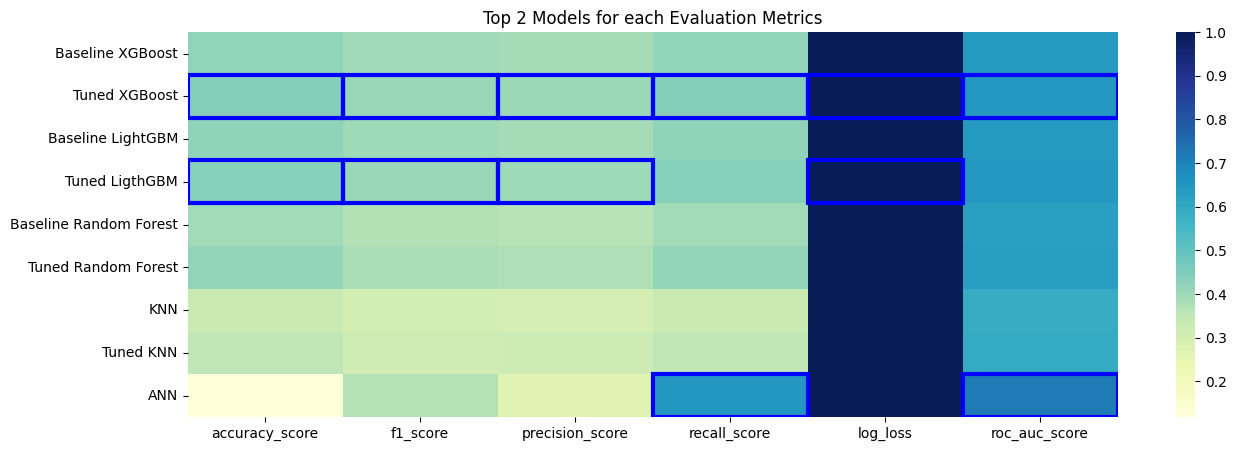

In [16]:
# for plotting graph
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
sns.color_palette("mako", as_cmap=True)
model_performance_score = evaluation.drop('models', axis=1)
fig,ax = plt.subplots(figsize=(15, 5), facecolor='w', edgecolor='k')
ax = sns.heatmap(model_performance_score, yticklabels=evaluation['models'],cmap="YlGnBu", vmax=1)
column_best = model_performance_score.idxmax(axis=0)
column_second_best = model_performance_score.replace(model_performance_score.max(), model_performance_score.min()).idxmax()

column_best['log_loss'] =evaluation['log_loss'].idxmin(axis=0)
column_second_best['log_loss'] = model_performance_score.replace(model_performance_score.min(), model_performance_score.max()).idxmin()['log_loss']

for col, variable in enumerate(evaluation.columns[1:]):
    position = evaluation.index.get_loc(column_best[variable])
    ax.add_patch(Rectangle((col, position),1,1, fill=False, edgecolor='blue', lw=3))
    
    position_second = evaluation.index.get_loc(column_second_best[variable])
    ax.add_patch(Rectangle((col, position_second),1,1, fill=False, edgecolor='blue', lw=3))
ax.set_title('Top 2 Models for each Evaluation Metrics')
plt.show()